# Correlation Exploration

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.linalg import svd

In [8]:
sentimentsUS = pd.read_csv("../../data/sentimentsUS.csv")
covidUS = pd.read_csv("../../data/covidDataUS.csv")

sentimentsAU = pd.read_csv("../../data/sentimentsAU.csv")
sentimentsGB = pd.read_csv("../../data/sentimentsGB.csv")

covid = pd.read_csv("../../data/owid-covid-data.csv")

Select columns which best represent the pandemic:

In [15]:
covid = covid[['iso',
               'date', 'new_cases', 'new_cases_smoothed',
               'new_deaths','new_deaths_smoothed', 
               'icu_patients', 'hosp_patients',
               'new_tests', 'new_tests_smoothed', 
               'new_vaccinations', 'new_vaccinations_smoothed',
               'gdp_per_capita']]

There are some columns in the sentiment columns which have weird values:

In [17]:
sum(sentimentsUS.timestamp == sentimentsUS.date)  # Are these columns necessary? They have the same (unexplained) values

688

In [13]:
sentimentsUS.drop(["timestamp", "date", "lang", "text", "day.1", "text_modified", "sentiment"], inplace=True, axis=1)
sentimentsAU.drop(["timestamp", "date", "lang", "text", "day.1", "text_modified", "sentiment"], inplace=True, axis=1)
sentimentsGB.drop(["timestamp", "date", "lang", "text", "day.1", "text_modified", "sentiment"], inplace=True, axis=1)

Complete NA values in sentiment analysis and covid data with values 0


In [14]:
sentimentsUS.fillna(0, inplace=True)
sentimentsAU.fillna(0, inplace=True)
sentimentsGB.fillna(0, inplace=True)
covid.fillna(0, inplace=True)

### 1. Join datasets on date

Get data where we have info on covid cases and sentiment analysis


In [15]:
cov_sent = pd.merge(covid, sentiments, how="inner", left_on="date", right_on="day")
cov_sent.drop("day", axis=1, inplace=True)

cov_sent.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 389
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      390 non-null    object 
 1   deathIncrease             390 non-null    int64  
 2   hospitalizedIncrease      390 non-null    int64  
 3   negativeIncrease          390 non-null    int64  
 4   positiveIncrease          390 non-null    int64  
 5   totalTestResultsIncrease  390 non-null    int64  
 6   negPercentage             390 non-null    float64
 7   netPercentage             390 non-null    float64
 8   posPercentage             390 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 30.5+ KB


Normalize data

In [16]:
cov_sent_norm = (cov_sent.drop("date",axis=1) - cov_sent.drop("date",axis=1).mean()) / cov_sent.drop("date",axis=1).std()
cov_sent_norm["date"] = cov_sent["date"]


### 2. Feauture engineering

Add feature MA from last 7 days, using both Simple Moving Average and Exponential Moving Average

In [17]:
days_ma = 7

cov_sent_sma = pd.DataFrame(cov_sent_norm["date"])
cov_sent_ema = pd.DataFrame(cov_sent_norm["date"])
for c in cov_sent_norm.drop("date", axis=1).columns:
    cov_sent_sma[c] = cov_sent_norm[c].rolling(days_ma).mean()
    cov_sent_ema[c] = cov_sent_norm[c].ewm(days_ma).mean()

cov_sent_sma.dropna(axis=0)
cov_sent_ema.dropna(axis=0)

,date,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
0,2021-03-07,-0.454850,-0.747794,-0.515218,-0.465714,0.373165,0.029827,0.714847,-0.818979
1,2021-03-06,-0.030361,-0.818119,-0.459709,-0.324159,0.592123,0.225609,-0.478015,0.273583
2,2021-03-05,0.304884,-0.331326,-0.020624,-0.228754,0.851426,0.238352,-0.478015,0.259361
3,2021-03-04,0.333888,-0.313524,-0.049189,-0.196027,0.907010,0.077236,-0.209866,0.144461
4,2021-03-03,0.523164,-0.205550,0.132066,-0.171568,0.865598,0.045087,-0.233458,0.206272
...,...,...,...,...,...,...,...,...,...
385,2020-02-15,-1.247732,-1.172604,-1.653860,-1.072901,-1.464924,-0.373349,0.640917,-0.287737
386,2020-02-14,-1.248586,-1.173163,-1.654459,-1.073347,-1.465281,0.824208,-0.165275,-0.738246
387,2020-02-13,-1.249334,-1.173652,-1.654984,-1.073737,-1.465593,0.380763,-0.365900,-0.022808
388,2020-02-12,-1.249987,-1.174080,-1.655443,-1.074079,-1.465866,1.484056,-1.046240,-0.506434


In [18]:
# TODO: Other moving averages

Now, to compare SMA vs EMA:

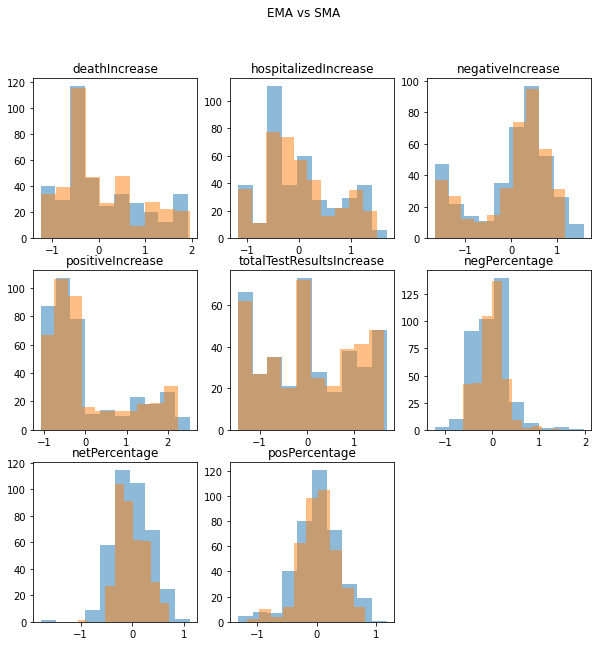

In [19]:
fig = plt.figure(figsize=(10,10))
i = 0
for col in cov_sent_sma.columns:
    i += 1
    if i == 1: continue
    ax = fig.add_subplot(3, 3, i-1)
    ax.hist(cov_sent_sma[col], alpha=0.5)
    ax.hist(cov_sent_ema[col], alpha=0.5)
    ax.set_title(col)
fig.suptitle("EMA vs SMA")
plt.show()


They are very similar, but we will still try to use both to see whether we find any interesting insights with any of them.

#### Derive / delta function with the day before

In [20]:
def delta(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


In [21]:
cov_sent_delta = pd.DataFrame(cov_sent_norm["date"])
for c in cov_sent_norm.drop("date", axis=1).columns:
    cov_sent_delta[c] = delta(cov_sent_norm[c])

### 3. Correlation Matrix

In [22]:
def plot_corr(df, size=10, show_numbers=True):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    mat = ax.matshow(corr)
    if show_numbers:
        for (i, j), z in np.ndenumerate(corr):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    ax.tick_params()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    fig.colorbar(mat)
    plt.show()
    return corr


Test correlation matrix


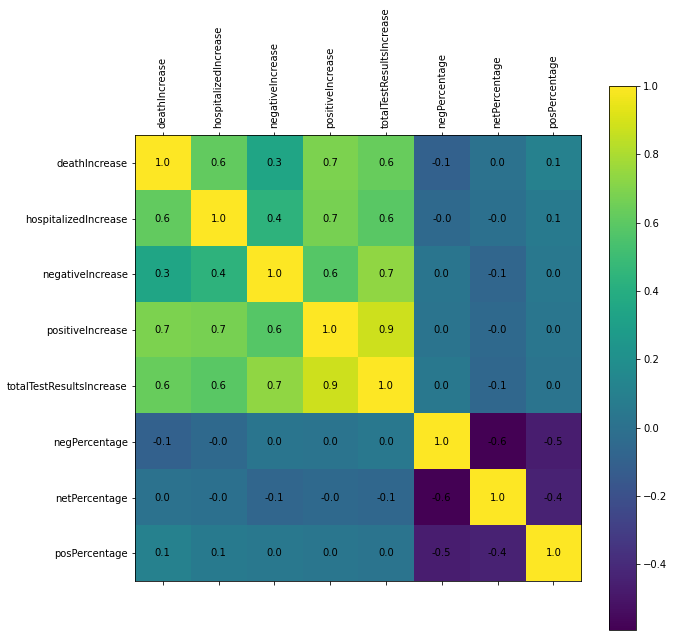

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.616425,0.341117,0.688346,0.628069,-0.099549,0.005269,0.105315
hospitalizedIncrease,0.616425,1.000000,0.435568,0.671240,0.592156,-0.048412,-0.007020,0.061748
negativeIncrease,0.341117,0.435568,1.000000,0.582133,0.735673,0.023487,-0.065906,0.046223
positiveIncrease,0.688346,0.671240,0.582133,1.000000,0.879269,0.017543,-0.045852,0.030816
totalTestResultsIncrease,0.628069,0.592156,0.735673,0.879269,1.000000,0.043955,-0.062459,0.019591
negPercentage,-0.099549,-0.048412,0.023487,0.017543,0.043955,1.000000,-0.592523,-0.464859
netPercentage,0.005269,-0.007020,-0.065906,-0.045852,-0.062459,-0.592523,1.000000,-0.437786
posPercentage,0.105315,0.061748,0.046223,0.030816,0.019591,-0.464859,-0.437786,1.000000


In [23]:
plot_corr(cov_sent_norm)

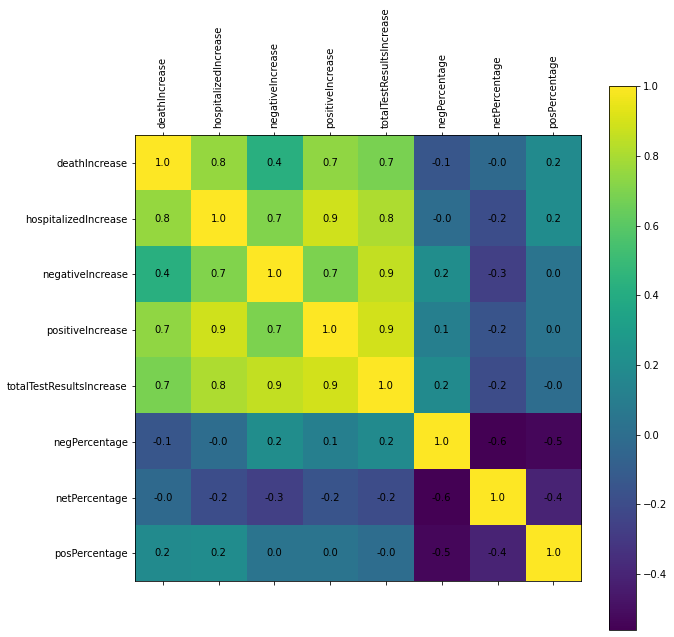

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.754346,0.425904,0.738883,0.683877,-0.140399,-0.028920,0.184629
hospitalizedIncrease,0.754346,1.000000,0.702165,0.885553,0.806268,-0.004653,-0.188378,0.197670
negativeIncrease,0.425904,0.702165,1.000000,0.692143,0.856837,0.207742,-0.263228,0.039577
positiveIncrease,0.738883,0.885553,0.692143,1.000000,0.892271,0.111100,-0.156445,0.037182
totalTestResultsIncrease,0.683877,0.806268,0.856837,0.892271,1.000000,0.187549,-0.197783,-0.005007
negPercentage,-0.140399,-0.004653,0.207742,0.111100,0.187549,1.000000,-0.560082,-0.532080
netPercentage,-0.028920,-0.188378,-0.263228,-0.156445,-0.197783,-0.560082,1.000000,-0.403424
posPercentage,0.184629,0.197670,0.039577,0.037182,-0.005007,-0.532080,-0.403424,1.000000


In [24]:
plot_corr(cov_sent_sma)

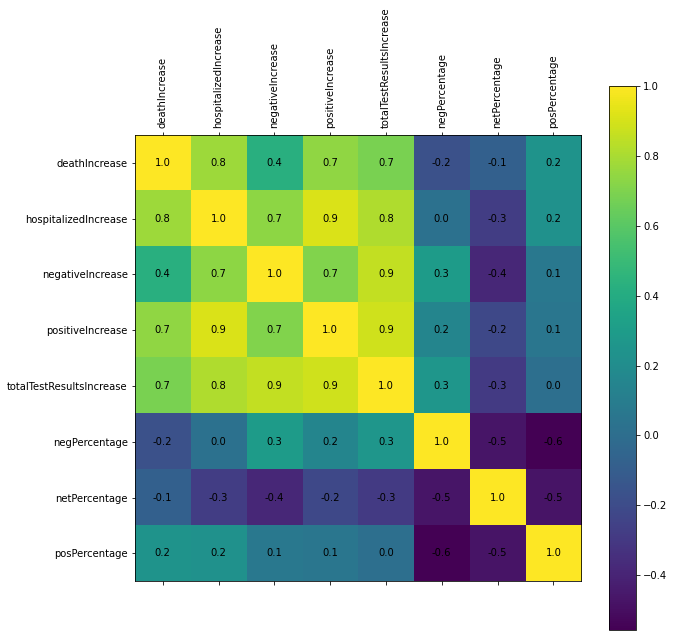

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.770860,0.423243,0.741003,0.689520,-0.170343,-0.077850,0.242714
hospitalizedIncrease,0.770860,1.000000,0.735424,0.912569,0.814854,0.026542,-0.274623,0.231522
negativeIncrease,0.423243,0.735424,1.000000,0.705281,0.858429,0.296695,-0.383306,0.064644
positiveIncrease,0.741003,0.912569,0.705281,1.000000,0.885917,0.152047,-0.217871,0.053265
totalTestResultsIncrease,0.689520,0.814854,0.858429,0.885917,1.000000,0.262516,-0.293436,0.014260
negPercentage,-0.170343,0.026542,0.296695,0.152047,0.262516,1.000000,-0.467011,-0.556936
netPercentage,-0.077850,-0.274623,-0.383306,-0.217871,-0.293436,-0.467011,1.000000,-0.474325
posPercentage,0.242714,0.231522,0.064644,0.053265,0.014260,-0.556936,-0.474325,1.000000


In [25]:
plot_corr(cov_sent_ema)

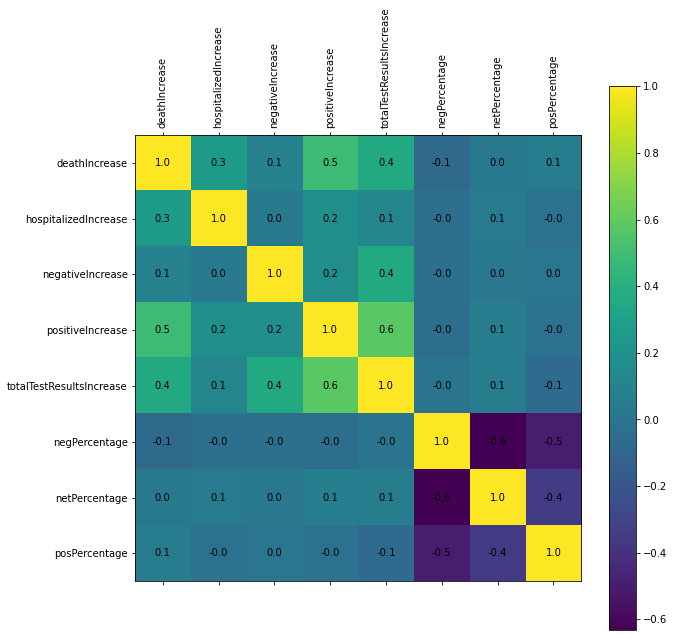

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.258782,0.090245,0.489791,0.359498,-0.068109,0.028267,0.050809
hospitalizedIncrease,0.258782,1.000000,0.031183,0.180485,0.109003,-0.033059,0.050228,-0.015932
negativeIncrease,0.090245,0.031183,1.000000,0.176427,0.360770,-0.030463,0.023303,0.010872
positiveIncrease,0.489791,0.180485,0.176427,1.000000,0.583174,-0.041943,0.068353,-0.025358
totalTestResultsIncrease,0.359498,0.109003,0.360770,0.583174,1.000000,-0.000741,0.055674,-0.061011
negPercentage,-0.068109,-0.033059,-0.030463,-0.041943,-0.000741,1.000000,-0.631002,-0.505857
netPercentage,0.028267,0.050228,0.023303,0.068353,0.055674,-0.631002,1.000000,-0.350006
posPercentage,0.050809,-0.015932,0.010872,-0.025358,-0.061011,-0.505857,-0.350006,1.000000


In [26]:
plot_corr(cov_sent_delta)

### 4. Pair-plotting

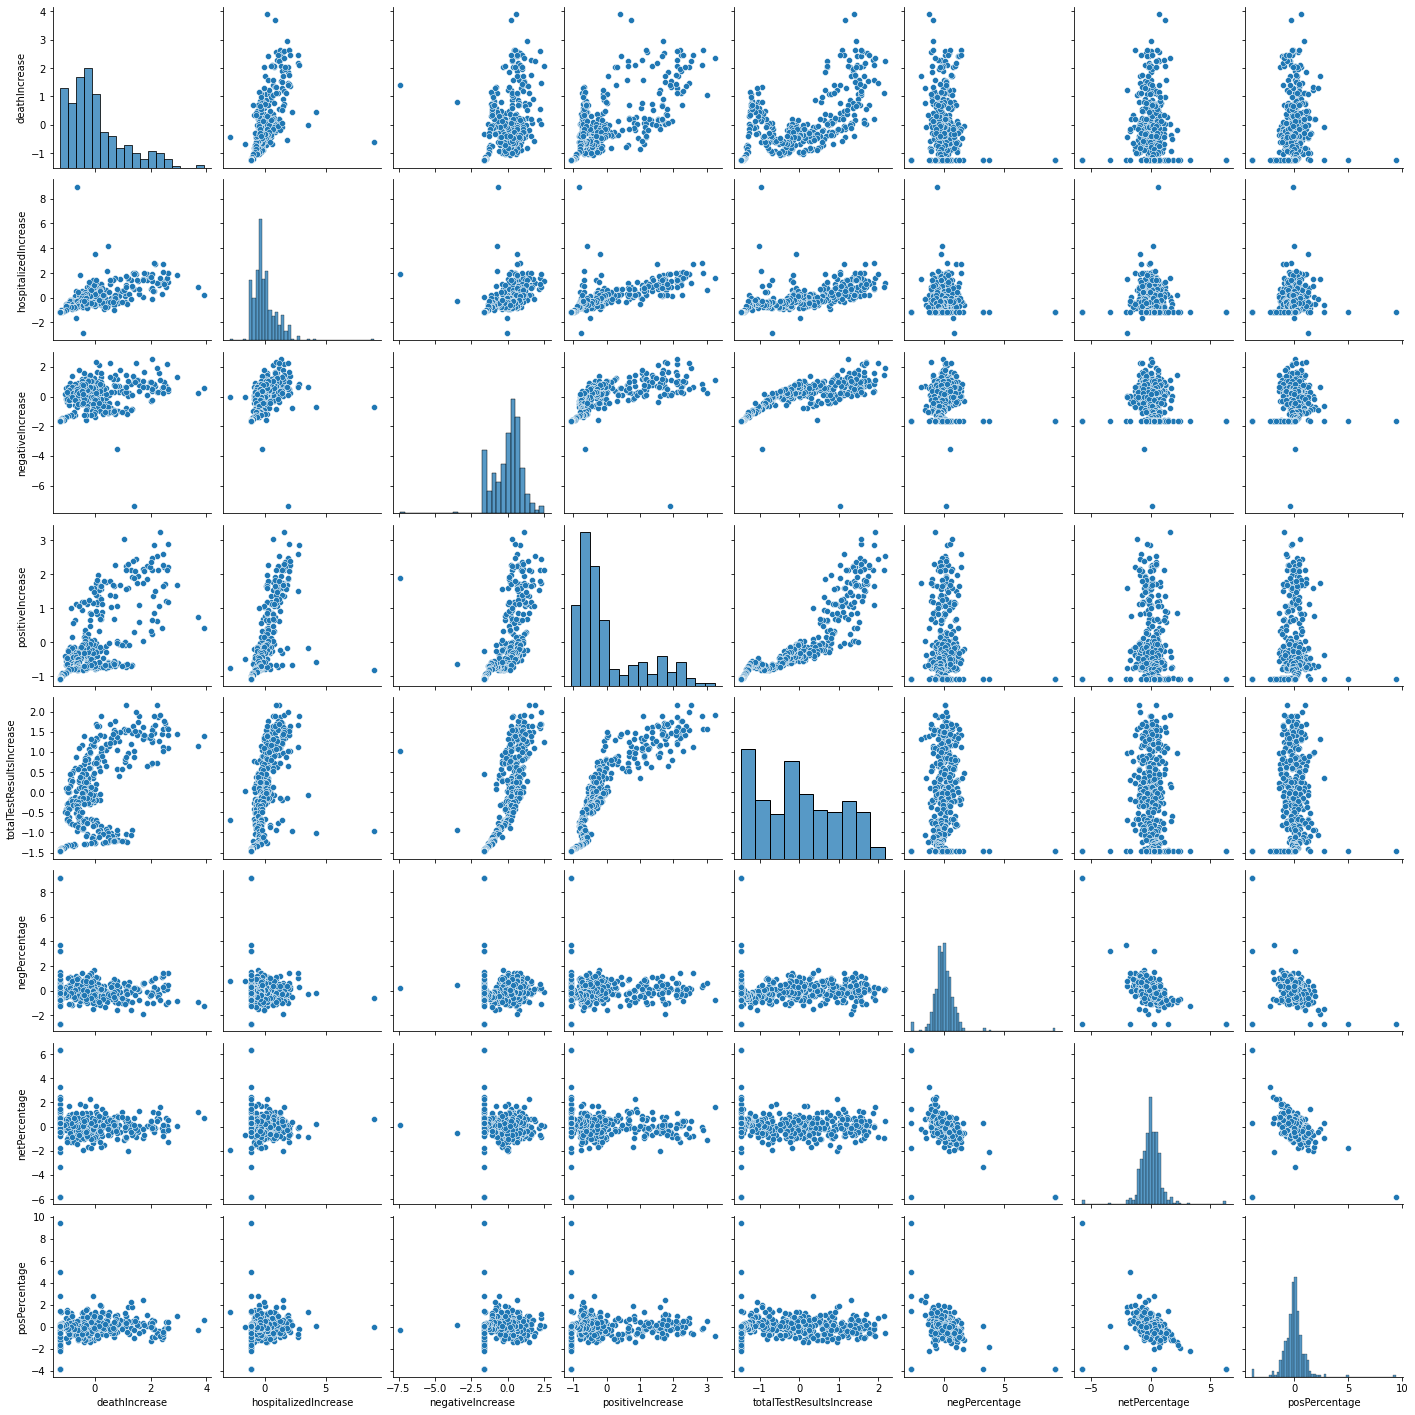

In [27]:
sns.pairplot(cov_sent_norm)
plt.show()

### 5. Mixing Moving Average data with Given data

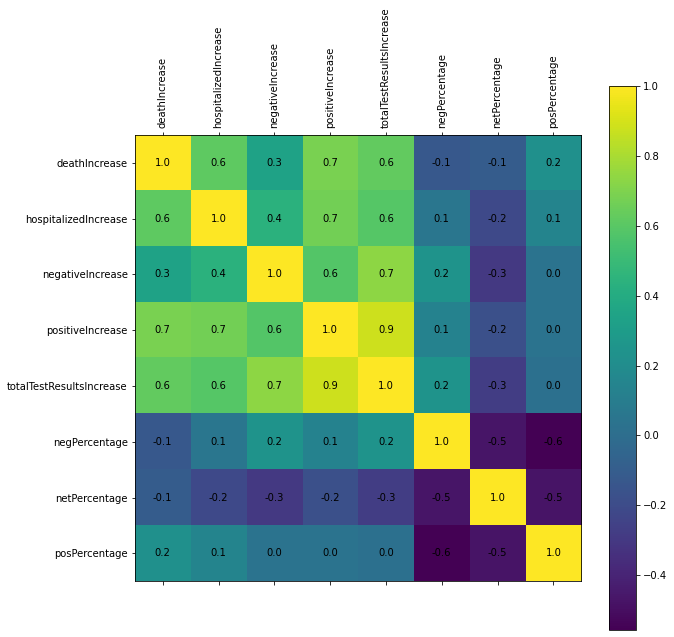

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.616425,0.341117,0.688346,0.628069,-0.128464,-0.104954,0.226478
hospitalizedIncrease,0.616425,1.000000,0.435568,0.671240,0.592156,0.054999,-0.216311,0.148419
negativeIncrease,0.341117,0.435568,1.000000,0.582133,0.735673,0.241964,-0.297423,0.038466
positiveIncrease,0.688346,0.671240,0.582133,1.000000,0.879269,0.131949,-0.179186,0.036938
totalTestResultsIncrease,0.628069,0.592156,0.735673,0.879269,1.000000,0.245210,-0.275955,0.015070
negPercentage,-0.128464,0.054999,0.241964,0.131949,0.245210,1.000000,-0.467011,-0.556936
netPercentage,-0.104954,-0.216311,-0.297423,-0.179186,-0.275955,-0.467011,1.000000,-0.474325
posPercentage,0.226478,0.148419,0.038466,0.036938,0.015070,-0.556936,-0.474325,1.000000


In [28]:
sent_cols = sentiments.columns.drop("day")
cov_cols  = covid.columns

# Sent: norm; Covid: EMA
mix1_ema_norm = pd.merge(cov_sent_norm[cov_cols], cov_sent_ema[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix1_ema_norm)

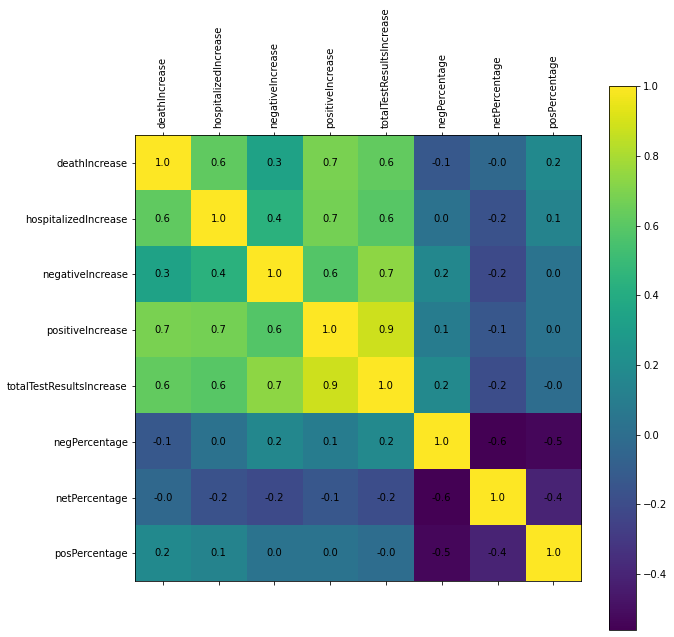

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.616425,0.341117,0.688346,0.628069,-0.132451,-0.032380,0.179386
hospitalizedIncrease,0.616425,1.000000,0.435568,0.671240,0.592156,0.028563,-0.166190,0.138304
negativeIncrease,0.341117,0.435568,1.000000,0.582133,0.735673,0.163602,-0.208018,0.031903
positiveIncrease,0.688346,0.671240,0.582133,1.000000,0.879269,0.095977,-0.136722,0.033728
totalTestResultsIncrease,0.628069,0.592156,0.735673,0.879269,1.000000,0.174418,-0.188365,-0.000130
negPercentage,-0.132451,0.028563,0.163602,0.095977,0.174418,1.000000,-0.560082,-0.532080
netPercentage,-0.032380,-0.166190,-0.208018,-0.136722,-0.188365,-0.560082,1.000000,-0.403424
posPercentage,0.179386,0.138304,0.031903,0.033728,-0.000130,-0.532080,-0.403424,1.000000


In [29]:
# Sent: norm; Covid: SMA
mix2_norm_sma = pd.merge(cov_sent_norm[cov_cols], cov_sent_sma[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix2_norm_sma)

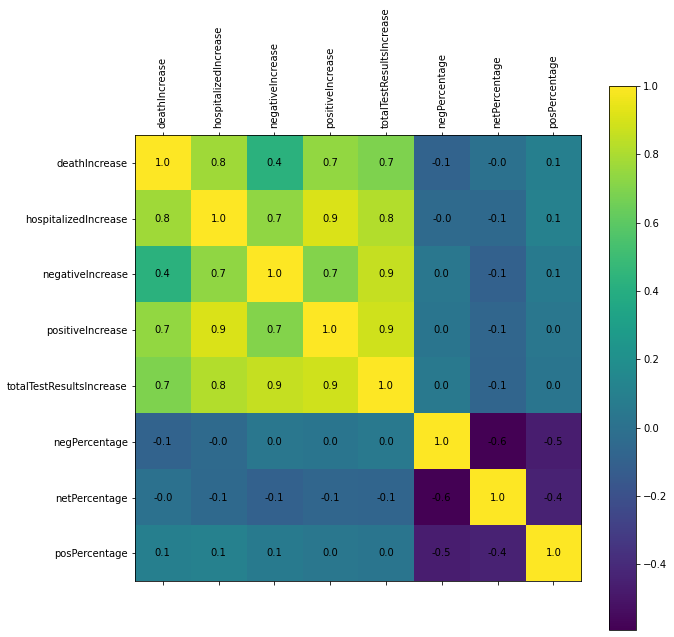

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.770860,0.423243,0.741003,0.689520,-0.084934,-0.000350,0.095180
hospitalizedIncrease,0.770860,1.000000,0.735424,0.912569,0.814854,-0.044699,-0.051276,0.106246
negativeIncrease,0.423243,0.735424,1.000000,0.705281,0.858429,0.040438,-0.096922,0.061394
positiveIncrease,0.741003,0.912569,0.705281,1.000000,0.885917,0.026494,-0.064305,0.041109
totalTestResultsIncrease,0.689520,0.814854,0.858429,0.885917,1.000000,0.049203,-0.074541,0.027013
negPercentage,-0.084934,-0.044699,0.040438,0.026494,0.049203,1.000000,-0.592523,-0.464859
netPercentage,-0.000350,-0.051276,-0.096922,-0.064305,-0.074541,-0.592523,1.000000,-0.437786
posPercentage,0.095180,0.106246,0.061394,0.041109,0.027013,-0.464859,-0.437786,1.000000


In [30]:
# Sent: EMA; Covid: norm
mix3_ema_norm = pd.merge(cov_sent_ema[cov_cols], cov_sent_norm[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix3_ema_norm)

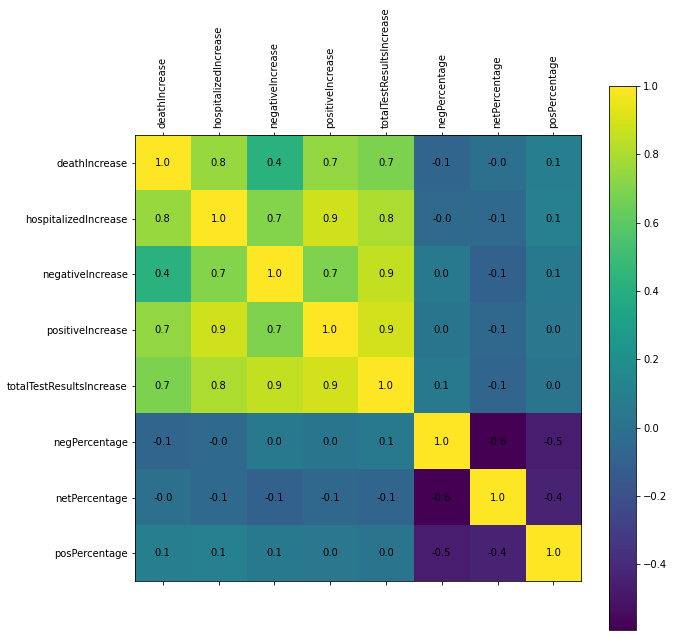

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.754346,0.425904,0.738883,0.683877,-0.075868,-0.002509,0.087652
hospitalizedIncrease,0.754346,1.000000,0.702165,0.885553,0.806268,-0.040514,-0.050118,0.100370
negativeIncrease,0.425904,0.702165,1.000000,0.692143,0.856837,0.048632,-0.096022,0.051022
positiveIncrease,0.738883,0.885553,0.692143,1.000000,0.892271,0.027490,-0.061095,0.036326
totalTestResultsIncrease,0.683877,0.806268,0.856837,0.892271,1.000000,0.052257,-0.070529,0.018971
negPercentage,-0.075868,-0.040514,0.048632,0.027490,0.052257,1.000000,-0.592523,-0.464859
netPercentage,-0.002509,-0.050118,-0.096022,-0.061095,-0.070529,-0.592523,1.000000,-0.437786
posPercentage,0.087652,0.100370,0.051022,0.036326,0.018971,-0.464859,-0.437786,1.000000


In [31]:
# Sent: SMA; Covid: norm
mix4_sma_norm = pd.merge(cov_sent_sma[cov_cols], cov_sent_norm[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix4_sma_norm)

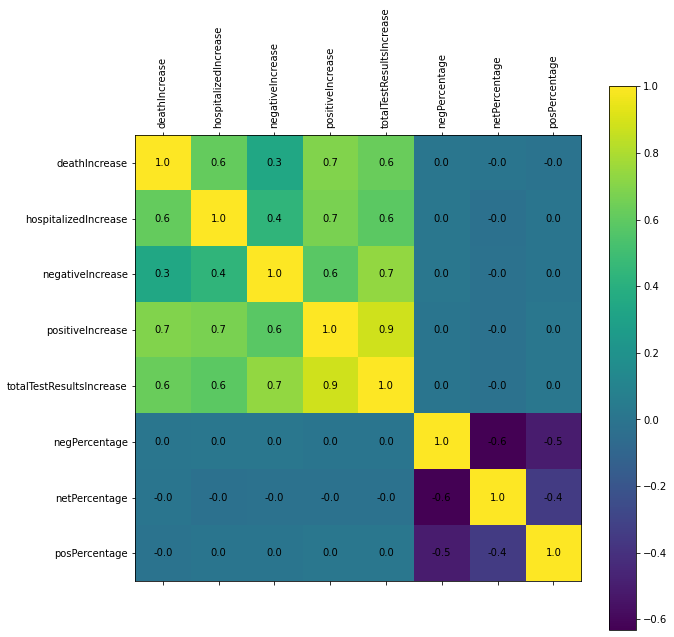

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.616425,0.341117,0.688346,0.628069,0.007610,-0.000066,-0.009115
hospitalizedIncrease,0.616425,1.000000,0.435568,0.671240,0.592156,0.017503,-0.023836,0.005370
negativeIncrease,0.341117,0.435568,1.000000,0.582133,0.735673,0.014880,-0.017700,0.001714
positiveIncrease,0.688346,0.671240,0.582133,1.000000,0.879269,0.004135,-0.016915,0.013815
totalTestResultsIncrease,0.628069,0.592156,0.735673,0.879269,1.000000,0.002772,-0.017097,0.015663
negPercentage,0.007610,0.017503,0.014880,0.004135,0.002772,1.000000,-0.631002,-0.505857
netPercentage,-0.000066,-0.023836,-0.017700,-0.016915,-0.017097,-0.631002,1.000000,-0.350006
posPercentage,-0.009115,0.005370,0.001714,0.013815,0.015663,-0.505857,-0.350006,1.000000


In [32]:
# Sent: norm; Covid: delta
mix5_norm_delta = pd.merge(cov_sent_norm[cov_cols], cov_sent_delta[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix5_norm_delta)

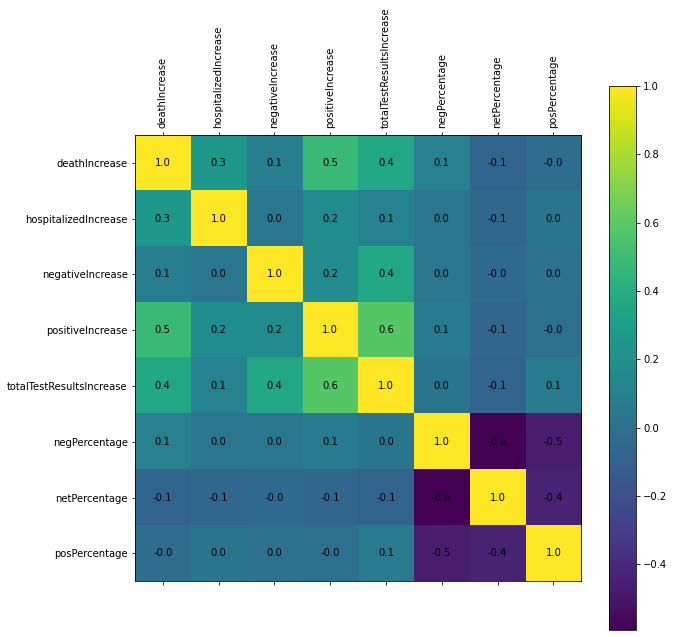

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,negPercentage,netPercentage,posPercentage
deathIncrease,1.000000,0.258782,0.090245,0.489791,0.359498,0.099276,-0.081949,-0.024900
hospitalizedIncrease,0.258782,1.000000,0.031183,0.180485,0.109003,0.032115,-0.058210,0.025617
negativeIncrease,0.090245,0.031183,1.000000,0.176427,0.360770,0.033892,-0.036127,0.000157
positiveIncrease,0.489791,0.180485,0.176427,1.000000,0.583174,0.070271,-0.068025,-0.006983
totalTestResultsIncrease,0.359498,0.109003,0.360770,0.583174,1.000000,0.027364,-0.084931,0.059356
negPercentage,0.099276,0.032115,0.033892,0.070271,0.027364,1.000000,-0.592523,-0.464859
netPercentage,-0.081949,-0.058210,-0.036127,-0.068025,-0.084931,-0.592523,1.000000,-0.437786
posPercentage,-0.024900,0.025617,0.000157,-0.006983,0.059356,-0.464859,-0.437786,1.000000


In [33]:
# Sent: delta; Covid: norm
mix6_delta_norm = pd.merge(cov_sent_delta[cov_cols], cov_sent_norm[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix6_delta_norm)

### 6. PCA: apply PCA on Covid data and see whether each sentiment can be distinguished

Both date and sentiment data should be dropped, as the first isn't helpful in PCA and the second features are the ones we are trying to distinguish.

We then choose the X values we are going to apply PCA on:

In [34]:
X = cov_sent_norm.drop(["date", *sent_cols], axis=1).fillna(0).values

Lets first check how many singular values we should select to obtain a 95% covariance explanation

In [35]:
U,S,V = svd(X, full_matrices=False)
rho = (S*S) / (S*S).sum()

threshold = 0.95

Plot variance threshold

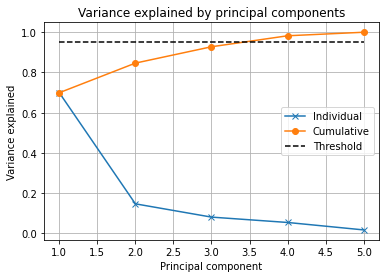

In [36]:
plt.figure()
plt.plot(range(1, len(rho)+1),rho, 'x-')
plt.plot(range(1, len(rho)+1),np.cumsum(rho), 'o-')
plt.plot([1,len(rho)],[threshold, threshold], 'k--')
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual', 'Cumulative', 'Threshold'])
plt.grid()
plt.show()

Choose number of components and apply PCA:

In [37]:
n_components = sum(np.cumsum(rho) < threshold) + 1  # How many number of components should be chosen?

# Apply PCA
pca = PCA(n_components=n_components)  # Chosen by previous plot
cov_sent_r = pca.fit_transform(X)

pca.explained_variance_ratio_

array([0.69938629, 0.14721874, 0.08122597, 0.05459552])

Create "column" to label each row for its maximum value between positive, negative or net sentiment

In [38]:
y = pd.Series(cov_sent_norm[[*sent_cols]].idxmax(axis=1))

Plot first two PCs

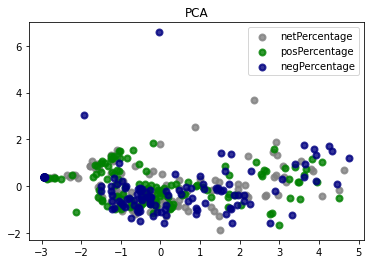

In [39]:
target_names = y.unique()
colors = ["gray", "green", "navy"]
lw = 2

for color, target_name in zip(colors, target_names):
    plt.scatter(
        cov_sent_r[y == target_name, 0], cov_sent_r[y == target_name, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA")
plt.show()